In [1]:
SEED = 123

import numpy as np
np.random.seed(SEED)

import pandas as pd
pd.options.display.max_rows = 10

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = "retina"

from tqdm.auto import tqdm

import seaborn as sns

In [2]:
%%time

transactions_dtype = dict(top_1_category_1="category",
                          top_1_category_2="category",
                          top_1_category_3="category",
                          top_1_installments="category")

base_historical_transactions_df = pd.read_csv("data/output/base_historical_transactions.csv",
                                              dtype=transactions_dtype)

assert base_historical_transactions_df.isnull().any().any() == False

display(base_historical_transactions_df)

,card_id,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,pct_of_category_2_2,pct_of_category_2_3,pct_of_category_2_4,pct_of_category_2_5,...,pct_of_installments_999,top_1_installments,top_1_city_id,min_purchase_amount,avg_purchase_amount,max_purchase_amount,sum_purchase_amount,top_1_purchase_amount,top_1_state_id,top_1_subsector_id
0,C_ID_00007093c1,0.765101,0.187919,0,0.187919,0.000000,0.000000,0.805369,0.000000,0.006711,...,0.0,1,244,-0.728876,-0.515739,1.507069,-76.845041,-0.721363,2,19
1,C_ID_0001238066,0.975610,0.016260,0,0.065041,0.772358,0.000000,0.000000,0.000000,0.162602,...,0.0,1,314,-0.734887,-0.589002,0.768095,-72.447201,-0.596643,9,19
2,C_ID_0001506ef0,0.939394,0.000000,0,0.000000,0.030303,0.000000,0.969697,0.000000,0.000000,...,0.0,0,137,-0.740491,-0.524271,1.493545,-34.601879,-0.724368,19,33
3,C_ID_0001793786,0.875000,0.009259,0,0.527778,0.050926,0.351852,0.069444,0.000000,0.000000,...,0.0,0,179,-0.745405,-0.170306,4.554145,-36.786013,-0.566620,-1,37
4,C_ID_000183fdda,0.951389,0.027778,0,0.027778,0.048611,0.006944,0.909722,0.000000,0.006944,...,0.0,1,161,-0.737892,-0.478041,2.764788,-68.837938,-0.671775,3,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325535,C_ID_ffff1d9928,0.750000,0.166667,0,0.166667,0.083333,0.000000,0.000000,0.750000,0.000000,...,0.0,1,114,-0.746893,-0.623139,0.004418,-7.477673,-0.742415,4,33
325536,C_ID_ffff579d3a,0.868421,0.000000,0,0.000000,0.991228,0.000000,0.000000,0.000000,0.008772,...,0.0,0,70,-0.739244,-0.704323,-0.491457,-80.292768,-0.716855,9,37
325537,C_ID_ffff756266,0.583333,0.125000,0,0.125000,0.875000,0.000000,0.000000,0.000000,0.000000,...,0.0,1,233,-0.746156,-0.229434,1.206403,-5.506420,-0.596643,9,20
325538,C_ID_ffff828181,0.873684,0.057895,0,0.057895,0.094737,0.805263,0.000000,0.036842,0.005263,...,0.0,1,96,-0.745405,-0.632101,0.109528,-120.099200,-0.671775,24,19


CPU times: user 3.22 s, sys: 153 ms, total: 3.38 s
Wall time: 2.68 s


In [3]:
%%time

purchase_amount_historical_transactions_df = pd.read_csv("data/output/purchase_amount_historical_transactions.csv")

assert purchase_amount_historical_transactions_df.isnull().any().any() == False

display(purchase_amount_historical_transactions_df)

,card_id,count_transactions_last_1_month,count_transactions_last_3_months,count_transactions_last_6_months,count_transactions_last_1_year,sum_purchase_amount_last_1_month,sum_purchase_amount_last_3_months,sum_purchase_amount_last_6_months,sum_purchase_amount_last_1_year,avg_purchase_amount_last_1_month,avg_purchase_amount_last_3_months,avg_purchase_amount_last_6_months,avg_purchase_amount_last_1_year
0,C_ID_00007093c1,12,34,62,145,6.259173,17.925021,34.452907,82.294976,-0.520861,-0.526947,-0.554098,-0.520763
1,C_ID_0001238066,24,87,123,123,14.894008,51.944653,74.473075,74.473075,-0.620584,-0.573779,-0.589002,-0.589002
2,C_ID_0001506ef0,6,31,43,59,5.033866,21.854048,29.535360,40.722328,-0.341129,-0.525638,-0.490571,-0.503854
3,C_ID_0001793786,0,0,58,208,0.000000,0.000000,35.481606,130.231322,-999.000000,-999.000000,-0.197187,-0.184364
4,C_ID_000183fdda,28,82,138,144,18.581724,54.392246,90.854182,93.085619,-0.558534,-0.440963,-0.497182,-0.478041
...,...,...,...,...,...,...,...,...,...,...,...,...,...
325535,C_ID_ffff1d9928,0,8,12,12,0.000000,4.869056,7.486509,7.486509,-999.000000,-0.607528,-0.623139,-0.623139
325536,C_ID_ffff579d3a,7,38,92,114,4.777108,26.492702,64.671372,80.292768,-0.682444,-0.697176,-0.702950,-0.704323
325537,C_ID_ffff756266,0,0,8,18,0.000000,0.000000,5.120374,9.109117,-999.000000,-999.000000,-0.640047,-0.241240
325538,C_ID_ffff828181,8,48,93,165,5.655453,31.504239,61.530996,105.830896,-0.706932,-0.656338,-0.661624,-0.640072


CPU times: user 763 ms, sys: 15.7 ms, total: 779 ms
Wall time: 580 ms


In [4]:
data_dtype = dict(feature_1="category",
                  feature_2="category",
                  feature_3="category")

train_df = pd.read_csv("data/input/train.csv", dtype=data_dtype, parse_dates=["first_active_month"])
test_df  = pd.read_csv("data/input/test.csv",  dtype=data_dtype, parse_dates=["first_active_month"])

train_test_first_active_month = pd.concat([train_df.first_active_month, test_df.first_active_month])
test_df.first_active_month.fillna(train_test_first_active_month.value_counts().index[0], inplace=True)

train_df = train_df.merge(base_historical_transactions_df,            how="left", on="card_id") \
                   .merge(purchase_amount_historical_transactions_df, how="left", on="card_id")

test_df  = test_df.merge(base_historical_transactions_df,            how="left", on="card_id") \
                  .merge(purchase_amount_historical_transactions_df, how="left", on="card_id")

assert train_df.isnull().any().any() == False
assert  test_df.isnull().any().any() == False

display(train_df, test_df)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,...,count_transactions_last_6_months,count_transactions_last_1_year,sum_purchase_amount_last_1_month,sum_purchase_amount_last_3_months,sum_purchase_amount_last_6_months,sum_purchase_amount_last_1_year,avg_purchase_amount_last_1_month,avg_purchase_amount_last_3_months,avg_purchase_amount_last_6_months,avg_purchase_amount_last_1_year
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.950000,0.000000,0,0.000000,...,164,260,15.549885,63.995254,104.706312,170.586807,-0.676082,-0.587893,-0.610294,-0.638341
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0.968571,0.088571,0,0.088571,...,164,307,0.000000,67.444965,109.069320,202.030474,-999.000000,-0.681344,-0.627936,-0.619315
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0.953488,0.000000,0,0.000000,...,11,31,0.661287,2.202346,6.989342,20.896063,-0.661287,-0.550586,-0.635395,-0.674067
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,1.000000,0.155844,0,0.155844,...,77,77,10.755511,18.492046,52.382555,52.382555,-0.672219,-0.660430,-0.642745,-0.642745
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.962406,0.112782,0,0.112782,...,133,133,46.787268,96.164251,110.703814,110.703814,0.284439,-0.346547,-0.366073,-0.366073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,2017-09-01,C_ID_963962de2c,3,2,1,-2.740821,0.913043,0.000000,0,0.000000,...,46,46,7.042325,19.852396,32.625247,32.625247,-0.704233,-0.709014,-0.709244,-0.709244
201913,2015-10-01,C_ID_1314773c0b,3,1,1,0.312917,0.851064,0.000000,0,0.000000,...,33,46,4.279115,13.058399,23.838073,32.704046,-0.713186,-0.725467,-0.722366,-0.710958
201914,2017-08-01,C_ID_7666735b3d,4,3,0,0.093494,0.931034,0.091954,0,0.183908,...,73,87,0.267201,10.275459,49.186807,59.802737,0.133601,0.305805,-0.447938,-0.381465
201915,2016-07-01,C_ID_73f5a0efd0,3,2,1,-4.676589,0.923077,0.000000,0,0.000000,...,10,23,0.000000,0.000000,6.843404,15.797056,-999.000000,-999.000000,-0.684340,-0.686829


,first_active_month,card_id,feature_1,feature_2,feature_3,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,...,count_transactions_last_6_months,count_transactions_last_1_year,sum_purchase_amount_last_1_month,sum_purchase_amount_last_3_months,sum_purchase_amount_last_6_months,sum_purchase_amount_last_1_year,avg_purchase_amount_last_1_month,avg_purchase_amount_last_3_months,avg_purchase_amount_last_6_months,avg_purchase_amount_last_1_year
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,0.647059,0.338235,0,0.338235,0.661765,...,34,68,0.000000,6.317461,22.171844,41.325086,-999.000000,-0.631746,-0.652113,-0.599025
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,0.987179,0.025641,0,0.025641,0.000000,...,2,56,1.272926,1.272926,1.272926,35.527407,-0.636463,-0.636463,-0.636463,-0.623032
2,2017-08-01,C_ID_b709037bc5,5,1,1,0.692308,0.076923,0,0.076923,0.076923,...,12,13,1.785255,6.580876,8.135143,8.657014,0.595085,0.734471,0.420893,0.348372
3,2017-12-01,C_ID_d27d835a9f,2,1,0,1.000000,0.000000,0,0.000000,1.000000,...,26,26,5.834118,13.875481,13.875481,13.875481,-0.648235,-0.526566,-0.526566,-0.526566
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,0.790909,0.000000,0,0.000000,0.036364,...,50,99,16.239797,42.289758,89.589656,122.073248,-0.398798,0.280416,0.762972,0.177022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,2017-10-01,C_ID_7a239d2eda,2,2,0,0.958904,0.000000,0,0.958904,0.041096,...,73,73,12.334527,34.671738,49.404782,49.404782,-0.685252,-0.679838,-0.676778,-0.676778
123619,2017-09-01,C_ID_75ace375ae,3,1,1,1.000000,0.000000,0,0.000000,0.857143,...,7,7,0.000000,2.873640,4.914616,4.914616,-999.000000,-0.718410,-0.702088,-0.702088
123620,2016-09-01,C_ID_21d56d950c,5,1,1,0.972973,0.081081,0,0.081081,0.027027,...,28,37,4.461747,5.555677,11.572142,15.994520,-0.141642,-0.185589,-0.097178,-0.177938
123621,2017-06-01,C_ID_6c46fc5a9d,2,1,0,0.693548,0.000000,0,0.000000,0.064516,...,25,62,0.000000,0.000000,16.099675,39.123627,-999.000000,-999.000000,-0.643987,-0.631026


In [5]:
for df in [train_df, test_df]:
    days_diff = train_df.first_active_month.max() - df.first_active_month
    df["years_since_first_active"]  = (days_diff / np.timedelta64(1, "Y")).astype(int)
    df["months_since_first_active"] = (days_diff / np.timedelta64(1, "M")).astype(int)
    
display(train_df, test_df)

,first_active_month,card_id,feature_1,feature_2,feature_3,target,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,...,sum_purchase_amount_last_1_month,sum_purchase_amount_last_3_months,sum_purchase_amount_last_6_months,sum_purchase_amount_last_1_year,avg_purchase_amount_last_1_month,avg_purchase_amount_last_3_months,avg_purchase_amount_last_6_months,avg_purchase_amount_last_1_year,years_since_first_active,months_since_first_active
0,2017-06-01,C_ID_92a2005557,5,2,1,-0.820283,0.950000,0.000000,0,0.000000,...,15.549885,63.995254,104.706312,170.586807,-0.676082,-0.587893,-0.610294,-0.638341,0,8
1,2017-01-01,C_ID_3d0044924f,4,1,0,0.392913,0.968571,0.088571,0,0.088571,...,0.000000,67.444965,109.069320,202.030474,-999.000000,-0.681344,-0.627936,-0.619315,1,13
2,2016-08-01,C_ID_d639edf6cd,2,2,0,0.688056,0.953488,0.000000,0,0.000000,...,0.661287,2.202346,6.989342,20.896063,-0.661287,-0.550586,-0.635395,-0.674067,1,18
3,2017-09-01,C_ID_186d6a6901,4,3,0,0.142495,1.000000,0.155844,0,0.155844,...,10.755511,18.492046,52.382555,52.382555,-0.672219,-0.660430,-0.642745,-0.642745,0,5
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.962406,0.112782,0,0.112782,...,46.787268,96.164251,110.703814,110.703814,0.284439,-0.346547,-0.366073,-0.366073,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,2017-09-01,C_ID_963962de2c,3,2,1,-2.740821,0.913043,0.000000,0,0.000000,...,7.042325,19.852396,32.625247,32.625247,-0.704233,-0.709014,-0.709244,-0.709244,0,5
201913,2015-10-01,C_ID_1314773c0b,3,1,1,0.312917,0.851064,0.000000,0,0.000000,...,4.279115,13.058399,23.838073,32.704046,-0.713186,-0.725467,-0.722366,-0.710958,2,28
201914,2017-08-01,C_ID_7666735b3d,4,3,0,0.093494,0.931034,0.091954,0,0.183908,...,0.267201,10.275459,49.186807,59.802737,0.133601,0.305805,-0.447938,-0.381465,0,6
201915,2016-07-01,C_ID_73f5a0efd0,3,2,1,-4.676589,0.923077,0.000000,0,0.000000,...,0.000000,0.000000,6.843404,15.797056,-999.000000,-999.000000,-0.684340,-0.686829,1,19


,first_active_month,card_id,feature_1,feature_2,feature_3,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,...,sum_purchase_amount_last_1_month,sum_purchase_amount_last_3_months,sum_purchase_amount_last_6_months,sum_purchase_amount_last_1_year,avg_purchase_amount_last_1_month,avg_purchase_amount_last_3_months,avg_purchase_amount_last_6_months,avg_purchase_amount_last_1_year,years_since_first_active,months_since_first_active
0,2017-04-01,C_ID_0ab67a22ab,3,3,1,0.647059,0.338235,0,0.338235,0.661765,...,0.000000,6.317461,22.171844,41.325086,-999.000000,-0.631746,-0.652113,-0.599025,0,10
1,2017-01-01,C_ID_130fd0cbdd,2,3,0,0.987179,0.025641,0,0.025641,0.000000,...,1.272926,1.272926,1.272926,35.527407,-0.636463,-0.636463,-0.636463,-0.623032,1,13
2,2017-08-01,C_ID_b709037bc5,5,1,1,0.692308,0.076923,0,0.076923,0.076923,...,1.785255,6.580876,8.135143,8.657014,0.595085,0.734471,0.420893,0.348372,0,6
3,2017-12-01,C_ID_d27d835a9f,2,1,0,1.000000,0.000000,0,0.000000,1.000000,...,5.834118,13.875481,13.875481,13.875481,-0.648235,-0.526566,-0.526566,-0.526566,0,2
4,2015-12-01,C_ID_2b5e3df5c2,5,1,1,0.790909,0.000000,0,0.000000,0.036364,...,16.239797,42.289758,89.589656,122.073248,-0.398798,0.280416,0.762972,0.177022,2,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,2017-10-01,C_ID_7a239d2eda,2,2,0,0.958904,0.000000,0,0.958904,0.041096,...,12.334527,34.671738,49.404782,49.404782,-0.685252,-0.679838,-0.676778,-0.676778,0,4
123619,2017-09-01,C_ID_75ace375ae,3,1,1,1.000000,0.000000,0,0.000000,0.857143,...,0.000000,2.873640,4.914616,4.914616,-999.000000,-0.718410,-0.702088,-0.702088,0,5
123620,2016-09-01,C_ID_21d56d950c,5,1,1,0.972973,0.081081,0,0.081081,0.027027,...,4.461747,5.555677,11.572142,15.994520,-0.141642,-0.185589,-0.097178,-0.177938,1,17
123621,2017-06-01,C_ID_6c46fc5a9d,2,1,0,0.693548,0.000000,0,0.000000,0.064516,...,0.000000,0.000000,16.099675,39.123627,-999.000000,-999.000000,-0.643987,-0.631026,0,8


In [6]:
class AddYearAndMonthTransformer:
    def call(self, df):
        for attr in ["year", "month"]:
            df["first_active_month" + "_" + attr] = getattr(df.first_active_month.dt, attr)

        return df.drop("first_active_month", axis=1)
    
add_year_and_month_transformer = AddYearAndMonthTransformer()

train_df = add_year_and_month_transformer.call(train_df)
test_df  = add_year_and_month_transformer.call(test_df)

display(train_df, test_df)

,card_id,feature_1,feature_2,feature_3,target,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,...,sum_purchase_amount_last_6_months,sum_purchase_amount_last_1_year,avg_purchase_amount_last_1_month,avg_purchase_amount_last_3_months,avg_purchase_amount_last_6_months,avg_purchase_amount_last_1_year,years_since_first_active,months_since_first_active,first_active_month_year,first_active_month_month
0,C_ID_92a2005557,5,2,1,-0.820283,0.950000,0.000000,0,0.000000,0.988462,...,104.706312,170.586807,-0.676082,-0.587893,-0.610294,-0.638341,0,8,2017,6
1,C_ID_3d0044924f,4,1,0,0.392913,0.968571,0.088571,0,0.088571,0.911429,...,109.069320,202.030474,-999.000000,-0.681344,-0.627936,-0.619315,1,13,2017,1
2,C_ID_d639edf6cd,2,2,0,0.688056,0.953488,0.000000,0,0.000000,0.093023,...,6.989342,20.896063,-0.661287,-0.550586,-0.635395,-0.674067,1,18,2016,8
3,C_ID_186d6a6901,4,3,0,0.142495,1.000000,0.155844,0,0.155844,0.155844,...,52.382555,52.382555,-0.672219,-0.660430,-0.642745,-0.642745,0,5,2017,9
4,C_ID_cdbd2c0db2,1,3,0,-0.159749,0.962406,0.112782,0,0.112782,0.075188,...,110.703814,110.703814,0.284439,-0.346547,-0.366073,-0.366073,0,3,2017,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201912,C_ID_963962de2c,3,2,1,-2.740821,0.913043,0.000000,0,0.000000,0.304348,...,32.625247,32.625247,-0.704233,-0.709014,-0.709244,-0.709244,0,5,2017,9
201913,C_ID_1314773c0b,3,1,1,0.312917,0.851064,0.000000,0,0.000000,1.000000,...,23.838073,32.704046,-0.713186,-0.725467,-0.722366,-0.710958,2,28,2015,10
201914,C_ID_7666735b3d,4,3,0,0.093494,0.931034,0.091954,0,0.183908,0.057471,...,49.186807,59.802737,0.133601,0.305805,-0.447938,-0.381465,0,6,2017,8
201915,C_ID_73f5a0efd0,3,2,1,-4.676589,0.923077,0.000000,0,0.000000,1.000000,...,6.843404,15.797056,-999.000000,-999.000000,-0.684340,-0.686829,1,19,2016,7


,card_id,feature_1,feature_2,feature_3,pct_of_authorized_transactions,pct_of_category_1_1,top_1_category_1,pct_of_category_2_missing,pct_of_category_2_1,pct_of_category_2_2,...,sum_purchase_amount_last_6_months,sum_purchase_amount_last_1_year,avg_purchase_amount_last_1_month,avg_purchase_amount_last_3_months,avg_purchase_amount_last_6_months,avg_purchase_amount_last_1_year,years_since_first_active,months_since_first_active,first_active_month_year,first_active_month_month
0,C_ID_0ab67a22ab,3,3,1,0.647059,0.338235,0,0.338235,0.661765,0.0,...,22.171844,41.325086,-999.000000,-0.631746,-0.652113,-0.599025,0,10,2017,4
1,C_ID_130fd0cbdd,2,3,0,0.987179,0.025641,0,0.025641,0.000000,0.0,...,1.272926,35.527407,-0.636463,-0.636463,-0.636463,-0.623032,1,13,2017,1
2,C_ID_b709037bc5,5,1,1,0.692308,0.076923,0,0.076923,0.076923,0.0,...,8.135143,8.657014,0.595085,0.734471,0.420893,0.348372,0,6,2017,8
3,C_ID_d27d835a9f,2,1,0,1.000000,0.000000,0,0.000000,1.000000,0.0,...,13.875481,13.875481,-0.648235,-0.526566,-0.526566,-0.526566,0,2,2017,12
4,C_ID_2b5e3df5c2,5,1,1,0.790909,0.000000,0,0.000000,0.036364,0.0,...,89.589656,122.073248,-0.398798,0.280416,0.762972,0.177022,2,26,2015,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123618,C_ID_7a239d2eda,2,2,0,0.958904,0.000000,0,0.958904,0.041096,0.0,...,49.404782,49.404782,-0.685252,-0.679838,-0.676778,-0.676778,0,4,2017,10
123619,C_ID_75ace375ae,3,1,1,1.000000,0.000000,0,0.000000,0.857143,0.0,...,4.914616,4.914616,-999.000000,-0.718410,-0.702088,-0.702088,0,5,2017,9
123620,C_ID_21d56d950c,5,1,1,0.972973,0.081081,0,0.081081,0.027027,0.0,...,11.572142,15.994520,-0.141642,-0.185589,-0.097178,-0.177938,1,17,2016,9
123621,C_ID_6c46fc5a9d,2,1,0,0.693548,0.000000,0,0.000000,0.064516,0.0,...,16.099675,39.123627,-999.000000,-999.000000,-0.643987,-0.631026,0,8,2017,6


In [7]:
X_train, y_train = train_df.drop(["card_id", "target"], axis=1), train_df.target

X_test = test_df.drop("card_id", axis=1)

In [8]:
%%time

model = RandomForestRegressor(n_estimators=100, max_features="sqrt", max_depth=10, n_jobs=-1, random_state=SEED)
scores = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10))
print("CV: %.4f +/- %.4f" % (scores.mean(), scores.std() ** 2))

CV: 3.7713 +/- 0.0052
CPU times: user 9.97 s, sys: 1.44 s, total: 11.4 s
Wall time: 1min 23s


In [9]:
%%time

model.fit(X_train, y_train)

CPU times: user 1min 5s, sys: 143 ms, total: 1min 6s
Wall time: 9.03 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=123, verbose=0, warm_start=False)

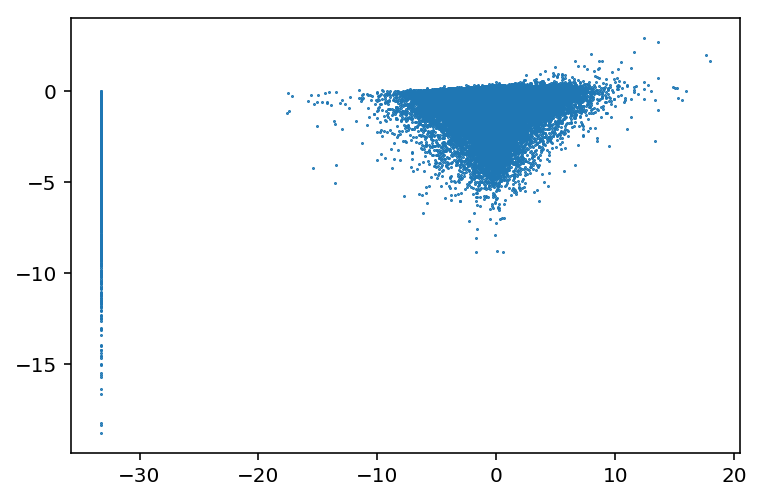

In [10]:
plt.scatter(y_train, model.predict(X_train), s=0.25);

In [11]:
%%time

y_test = model.predict(X_test)

CPU times: user 1.79 s, sys: 56.7 ms, total: 1.85 s
Wall time: 556 ms


In [12]:
submission_df = pd.read_csv("data/input/sample_submission.csv")
submission_df.target = y_test
submission_df.head()

,card_id,target
0,C_ID_0ab67a22ab,-2.965328
1,C_ID_130fd0cbdd,-0.372866
2,C_ID_b709037bc5,0.059996
3,C_ID_d27d835a9f,0.024198
4,C_ID_2b5e3df5c2,-0.107684


In [13]:
submission_df.isnull().any().any()

False

In [14]:
submission_df.to_csv("submission.csv", index=False)

In [15]:
!head submission.csv

card_id,target
C_ID_0ab67a22ab,-2.965327927267845
C_ID_130fd0cbdd,-0.37286561989271483
C_ID_b709037bc5,0.05999592302503265
C_ID_d27d835a9f,0.024198383029447643
C_ID_2b5e3df5c2,-0.10768404071102321
C_ID_5814b4f13c,0.07403100206282331
C_ID_a1b3c75277,-0.005903505639562926
C_ID_f7cada36d3,-0.20761834975044408
C_ID_9d2bc8dfc4,0.02075549747059132


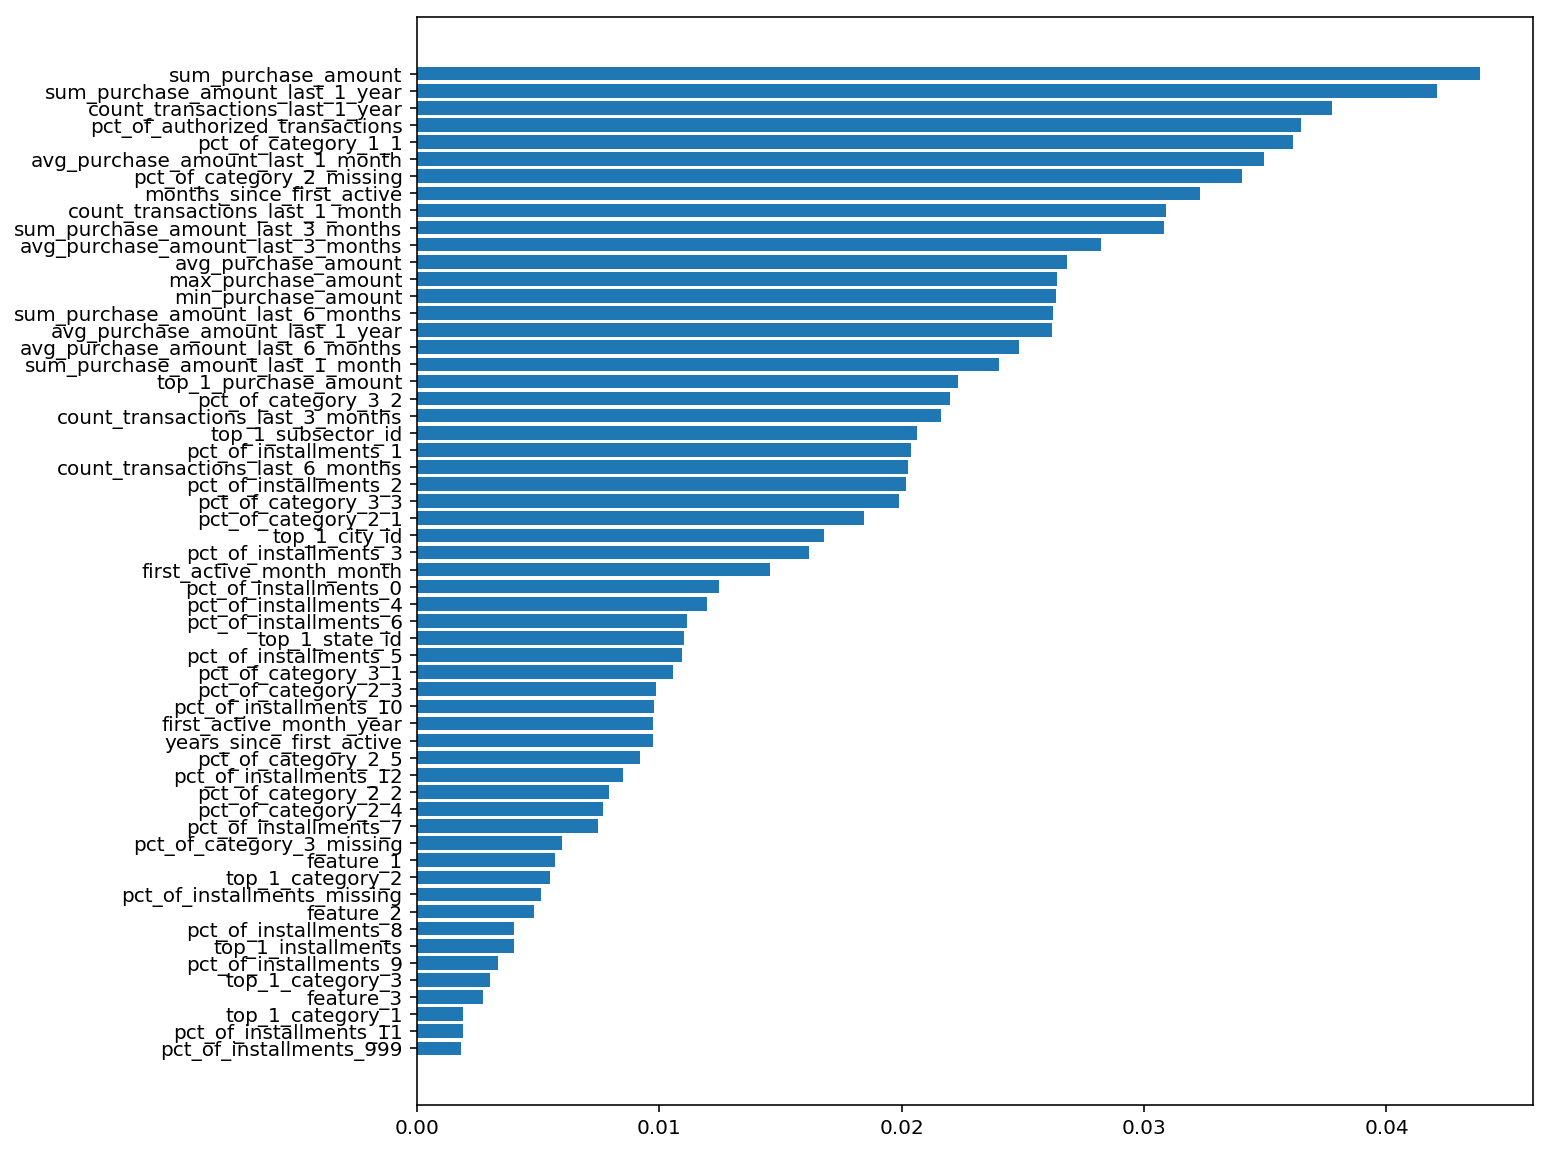

In [16]:
idx = np.argsort(model.feature_importances_)

importances = model.feature_importances_[idx]
columns = X_train.columns.values[idx]

plt.figure(figsize=(10, 10))
plt.barh(columns, importances);